In [1]:
import sys
print(sys.executable) 

/home/aps/miniconda3/envs/options/bin/python


In [2]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import optax

In [3]:
# to make envs available in notebooks
# pip install jax pandas matplotlib seaborn scikit-learn optax jaxopt
# conda install notebook ipykernel
# ipython kernel install --user --name=options

In [4]:
# needed this on mac to get autocomplete to work
# %config Completer.use_jedi = False

## Use jax to implement major models

### What device is being used for computing?

Use conda to install cuda: conda install cuda -c nvidia

In [5]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [6]:
jax.devices()[0].platform

'gpu'

In [7]:
def jax_has_gpu():
    try:
        _ = jax.device_put(jax.numpy.ones(1), device=jax.devices('gpu')[0])
        return True
    except:
        return False
jax_has_gpu()

True

### Fit a linear regression

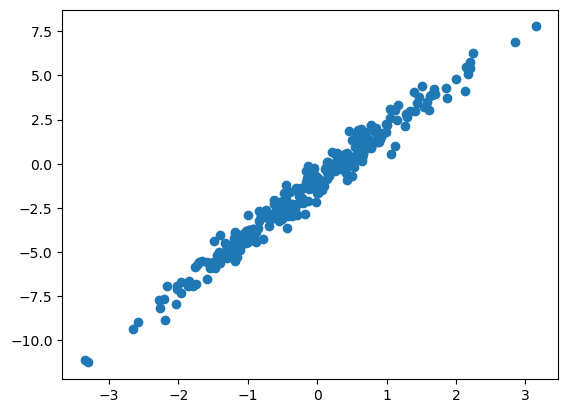

In [8]:
import numpy as np
import matplotlib.pyplot as plt

n = 300
xs = np.random.normal(size=(n,))
noise = np.random.normal(scale=0.5, size=(n,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

In [9]:
# theta = [w, b] - model parameters
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

Loss function is the sum of squared errors, $ L = \frac{\Sigma (y - y_{pred})^2}{N}$

In [10]:
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

In [11]:
loss_fn((3,1), 0, 4)

Array(9., dtype=float32)

In [13]:
loss_fn((3,1), xs, ys)

Array(4.327121, dtype=float32)

Use gradient discend to find the optimal parameters, 
$$
\theta_{updated}=\theta - \lambda\nabla_{\theta}L(\theta, x, y)
$$
where $\lambda$ is learning rate.

In [14]:
@jax.jit
def update(theta, x, y, lr=0.1):
  return theta - lr * grad(loss_fn)(theta, x, y)

In [15]:
theta = jnp.array([1., 1.])
theta

Array([1., 1.], dtype=float32)

In [16]:
grad(loss_fn)(theta, 1., 1.)

Array([2., 2.], dtype=float32)

In [17]:
grad(loss_fn)(theta, 2., -1.)

Array([16.,  8.], dtype=float32)

Gradient returns the average gradient for vectors of variables.

In [18]:
grad(loss_fn)(theta, jnp.array([1., 2.]), jnp.array([1., -1.]))

Array([9., 5.], dtype=float32)

In [19]:
# initial parateters
theta = jnp.array([1., 1.])
theta
n_iterations = 200
lr = .1
for i in range(n_iterations):
    theta = update(theta, xs, ys, lr=lr)
theta

Array([ 3.0025022, -1.0143135], dtype=float32)

### Compute greeks of Black-Scholes option prices with jax.grad

In [20]:
#@jax.jit
def bs_call(S, X, T, sig, r):
    d1 = (jnp.log(S/X) + (r + .5 * sig**2) * T)/(jnp.sqrt(T) * sig)
    print(f'd1 = {d1}')
    d2 = d1 - jnp.sqrt(T) * sig
    print(f'd2 = {d2}')
    c = S * jax.scipy.stats.norm.cdf(d1) - X * jnp.exp(-r*T)* jax.scipy.stats.norm.cdf(d2)
    print(f'delta = {jax.scipy.stats.norm.cdf(d1)}')
    return c

In [21]:
S=60.
X=65.
r=.08
sig=.30
T=.25
bs_call(S, X, T, sig, r)

d1 = -0.3252846896648407
d2 = -0.4752846956253052
delta = 0.3724828064441681


Array(2.1333694, dtype=float32)

In [22]:
# pars = [S, X, T, sig, r]
def euro_call(pars):
    S, X, T, sig, r = pars
    c = bs_call(S, X, T, sig, r)
    return c

In [23]:
euro_call([S, X, T, sig, r])

d1 = -0.3252846896648407
d2 = -0.4752846956253052
delta = 0.3724828064441681


Array(2.1333694, dtype=float32)

In [24]:
pars = [S, X, T, sig, r]
jax.grad(euro_call)(pars)

d1 = Traced<ConcreteArray(-0.3252846896648407, dtype=float32, weak_type=True)>with<JVPTrace(level=2/0)> with
  primal = Array(-0.3252847, dtype=float32, weak_type=True)
  tangent = Traced<ShapedArray(float32[], weak_type=True)>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[], weak_type=True), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f97e819e3b0>, in_tracers=(Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.15000000596046448, dtype=float32, weak_type=True):JaxprTrace(level=1/0)>, Traced<ConcreteArray(-0.048792704939842224, dtype=float32, weak_type=True):JaxprTrace(level=1/0)>, Traced<ConcreteArray(44.44444274902344, dtype=float32, weak_type=True):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x7f97c4725620; to 'JaxprTracer' at 0x7f97c4725580>], out_avals=[ShapedArray(float32[], weak_type=True)], primitive=pjit, params={'jaxpr': 

[Array(0.3724828, dtype=float32, weak_type=True),
 Array(-0.31100923, dtype=float32, weak_type=True),
 Array(8.428175, dtype=float32, weak_type=True),
 Array(11.351544, dtype=float32, weak_type=True),
 Array(5.0539, dtype=float32, weak_type=True)]

In [19]:
np.sqrt(4) + 2

4.0

### Random numbers

In [25]:
key = jax.random.PRNGKey(42)
print(random.normal(key, shape=(5,)))
print(random.normal(key, shape=(5,)))

[ 0.6122652  1.1225883 -0.8544134 -0.8127325 -0.890405 ]
[ 0.6122652  1.1225883 -0.8544134 -0.8127325 -0.890405 ]


In [26]:
# never reuse a key
key = jax.random.PRNGKey(42)
key, subkey = random.split(key)
print(random.normal(subkey, shape=(5,)))
key, subkey = random.split(key)
print(random.normal(subkey, shape=(5,)))

[-0.55338794  0.944283   -0.74176395 -0.5769758   1.1251862 ]
[-0.32761317 -0.4066346   1.2469071   1.1900425   1.100263  ]


## Common models

### Linear model

$y = wx + b$

Generate observed values

In [27]:
key = jax.random.PRNGKey(212)
w = jnp.array([1., -1., 3., 5., -2.])
b = 2
theta_true = jnp.append(w, b)
print(theta_true)

[ 1. -1.  3.  5. -2.  2.]


In [28]:
@jax.jit
def model(theta, x):
    w = theta[:-1]
    b = theta[-1]
    y = jnp.dot(w, x) + b
    return y

model_vmap = jax.vmap(model, in_axes=[None, 1])

In [29]:
model(theta_true, jnp.array([1, 2, 3, 4, 5]))

Array(20., dtype=float32)

In [30]:
np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]).reshape(5, 2)

array([[1, 2],
       [3, 4],
       [5, 1],
       [2, 3],
       [4, 5]])

In [31]:
#model_vmap(theta, np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]).reshape(5, 2))

In [32]:
n_obs = 50
x_observed = jax.random.normal(key, shape=(5,n_obs))
print(x_observed.shape)
print(jnp.sum(x_observed, axis=1))


(5, 50)
[-1.9834338  3.6937184 -2.6479697  1.7907314 12.152573 ]


In [33]:
# observations - model plus some noise
y_observed = model(theta_true, x_observed) + jax.random.normal(key, shape=(n_obs,))
print(y_observed)

[  5.0615315    2.4697185   -3.1689072   -7.6509895   -3.878571
  11.230026     1.4037006    4.231458     9.178272     5.9207597
  -1.3583989   -4.3980184    5.34012      0.41575944  -1.9732018
  -8.83993      6.2698207   -2.5513077    6.314845    -8.689926
  -1.7106981   -5.669702     8.188997    10.294529     5.785759
  -5.8465557   17.606491     5.4771914   11.000769     7.3086863
  -3.7401242    6.7878776    8.182899     1.5911285    1.0267415
   4.3348236   -5.980621   -11.129906    -4.772352    -3.095614
  -0.26369235  -5.845175    -2.924248     3.485813    11.435972
  11.133466    -4.316735     0.92751515  -5.489374    -8.450031  ]


Text(0.5, 1.0, 'Noisy observations vs underlying model')

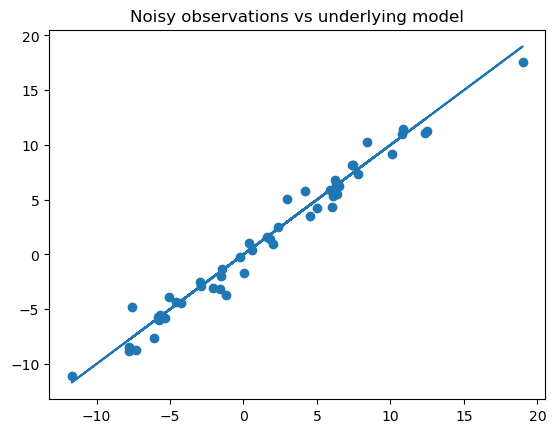

In [34]:
plt.scatter(model(theta_true, x_observed), y_observed)
plt.plot(model(theta_true, x_observed), model(theta_true, x_observed))
plt.title('Noisy observations vs underlying model')

In [36]:
%timeit model(theta_true, x_observed)

52.1 µs ± 3.77 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [37]:
y_observed = model_vmap(theta_true, x_observed)
print(y_observed)

[ 2.9883356e+00  2.3349292e+00 -1.5650353e+00 -6.1130486e+00
 -5.0836453e+00  1.2472522e+01  1.8045750e+00  5.0270214e+00
  1.0129258e+01  5.9141598e+00 -1.4724889e+00 -4.2724571e+00
  6.0810957e+00  5.5440164e-01 -1.5313125e+00 -7.7776632e+00
  6.5286217e+00 -2.9492378e+00  6.2737894e+00 -7.3210154e+00
  1.4330387e-02 -5.8055058e+00  7.4530363e+00  8.3956413e+00
  4.1605120e+00 -5.3344989e+00  1.8990658e+01  6.3681192e+00
  1.0795193e+01  7.7783060e+00 -1.1883299e+00  6.2501440e+00
  7.3560801e+00  1.6167397e+00  3.5765314e-01  6.0111747e+00
 -5.7826834e+00 -1.1694789e+01 -7.5610752e+00 -2.0660710e+00
 -2.2288561e-01 -5.6120420e+00 -2.8691716e+00  4.5343018e+00
  1.0853861e+01  1.2338906e+01 -4.6002135e+00  1.9807799e+00
 -5.6962886e+00 -7.8172445e+00]


In [38]:
# slower tham model?
%timeit model_vmap(theta_true, x_observed)

697 µs ± 3.82 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [39]:
# loss function - mean squared error
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

In [40]:
# update step
@jax.jit
def update(theta, x, y, lr=0.01):
  return theta - lr * grad(loss_fn)(theta, x, y)

In [41]:
# initial parateters
theta = jnp.array([1., 1., 1., 1., 1., 1.])
theta
n_iterations = 1000
lr = .01
for i in range(n_iterations):
    theta = update(theta, x_observed, y_observed, lr=lr)
print('True vs fitted parameters:')
print(jnp.vstack([jnp.round(theta, 4), theta_true]))


True vs fitted parameters:
[[ 1. -1.  3.  5. -2.  2.]
 [ 1. -1.  3.  5. -2.  2.]]


### Logistic regression classifier

First, we create data using bivariate normal distribution.

In [42]:
class1 = random.multivariate_normal(key,
                           mean=jnp.array([1, 1]),
                           cov=.5*np.array([1, .5, .5, 1]).reshape(2,2),
                          shape=[100,])
class1[:5,:]

Array([[ 2.2076726 ,  0.63324547],
       [ 0.53972983, -0.5107355 ],
       [ 1.6998711 ,  1.4444137 ],
       [-0.05809402,  1.3304108 ],
       [ 0.23326337,  0.6060622 ]], dtype=float32)

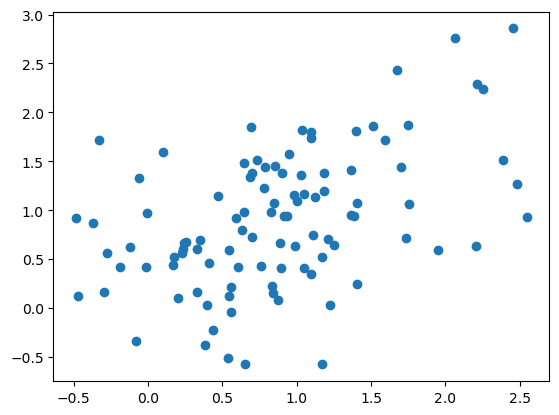

In [43]:
plt.scatter(class1[:, 0], class1[:, 1])

In [44]:
key, subkey = random.split(key)
class2 = random.multivariate_normal(key,
                           mean=jnp.array([3, 3]),
                           cov=.5*np.array([1, .7, .7, 1]).reshape(2,2),
                          shape=[100,])
class2[:5,:]

Array([[3.6587057, 3.276566 ],
       [2.3907404, 3.2305648],
       [2.9801316, 2.669557 ],
       [1.739017 , 1.6249541],
       [2.5033264, 2.8402581]], dtype=float32)

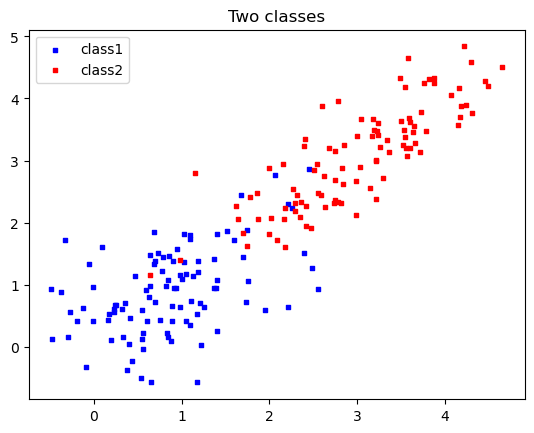

In [45]:

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(class1[:, 0], class1[:, 1], s=10, c='b', marker="s", label='class1')
ax1.scatter(class2[:, 0], class2[:, 1], s=10, c='r', marker="s", label='class2')
plt.title('Two classes')
plt.legend()


Logistic regression models the probability of belonging to $class1$ as
$$
p = \frac{1}{1+e^{-(wx + b)}},
$$
where, in our case, $w = (w_1, w_2), x = (x_1, x_2)$, and $b$ is a scalar.
The loss function at $p_k, y_k$ is defined as 

$$
\left\{
\begin{array}{l}
      -log(p_k),\ if\  y_k = 1\ \    (class 1),\\
      -log(1-p_k),\ if\  y_k=0 \ \    (class 2).
      \end{array}
  \right.
$$
Combining, we get cross entropy loss function

$$
L = -\Sigma_1^N (y_k\log(p_k) + (1-y_k)log(1-p_k)).
$$

In [46]:
# implement functions
@jax.jit
def sigmoid(t):
    return 1/(1 + jnp.exp(-t))

@jax.jit
def model(theta, x):
    w = theta[:-1]
    b = theta[-1]
    t = jnp.dot(w, x) + b
    p = sigmoid(t)
    return p

# loss function - cross entropy
def loss_fn(theta, x, y):
  p = model(theta, x)
#  print(theta.dtype)
#  print(y.dtype)
# print(y*(jnp.log(p) + (1-y)*jnp.log(1-p)))    
  return -jnp.mean(y*jnp.log(p) + (1-y)*jnp.log(1-p))

# update step
@jax.jit
def update(theta, x, y, lr=0.01):
  return theta - lr * grad(loss_fn)(theta, x, y)

In [47]:
class1[:5, :]

Array([[ 2.2076726 ,  0.63324547],
       [ 0.53972983, -0.5107355 ],
       [ 1.6998711 ,  1.4444137 ],
       [-0.05809402,  1.3304108 ],
       [ 0.23326337,  0.6060622 ]], dtype=float32)

In [48]:
theta = np.array([1., 1., 1.])
model(theta, class1[:5, :].transpose())

Array([0.97897756, 0.73672086, 0.98439276, 0.9065582 , 0.8628689 ],      dtype=float32)

In [54]:
loss_fn(theta, data[:,:-1].transpose(), lbl)

Array(3.5659707, dtype=float32)

In [50]:
# alternative cross entropy function
from sklearn.metrics import log_loss
lbl = jnp.concatenate((jnp.ones(shape=(len(class1),)), jnp.zeros(shape=(len(class2),))))
data = jnp.column_stack((jnp.row_stack((class1, class2)), lbl))
log_loss(lbl, model(theta, data[:,:-1].transpose()))

3.565970814956701

In [51]:
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)

In [52]:
BinaryCrossEntropy(lbl, model(theta, data[:,:-1].transpose()))

Array(3.5658102, dtype=float32)

In [56]:
update(theta, class1[:, :].transpose(), jnp.ones(shape=(len(class1),)))

Array([1.0003867, 1.0003953, 1.0009131], dtype=float32)

In [57]:
#input data
lbl = jnp.concatenate((jnp.ones(shape=(len(class1),)), jnp.zeros(shape=(len(class2),))))
data = jnp.column_stack((jnp.row_stack((class1, class2)), lbl))
print(data.shape)
print(data[:5, :])
print(data[-5:, :])
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    data[:,:-1], 
    data[:,-1], 
    test_size=0.3, random_state=212
)

(200, 3)
[[ 2.2076726   0.63324547  1.        ]
 [ 0.53972983 -0.5107355   1.        ]
 [ 1.6998711   1.4444137   1.        ]
 [-0.05809402  1.3304108   1.        ]
 [ 0.23326337  0.6060622   1.        ]]
[[4.2168283 4.838749  0.       ]
 [3.027188  2.895407  0.       ]
 [4.1475687 3.578512  0.       ]
 [3.8165798 4.3165026 0.       ]
 [0.9768336 1.3954045 0.       ]]


In [58]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_test.sum())

(140, 2)
(60, 2)
(140,)
(60,)
30.0


In [72]:
# fit parameters
# initial parateters
theta = jnp.array([1., 1., 1.])
n_iterations = 500
lr = .1
for i in range(n_iterations):
    #print(theta)
    theta = update(theta, X_train.transpose(), y_train, lr=lr)
    print(loss_fn(theta, X_train.transpose(), y_train), loss_fn(theta, X_test.transpose(), y_test))
print(theta)


3.1687317 2.9157207
2.6889741 2.48175
2.2205 2.059703
1.7718313 1.6576842
1.3596144 1.2906746
1.012599 0.98337924
0.7634139 0.7628756
0.6172642 0.6326694
0.5421018 0.56481814
0.50348717 0.5293926
0.4822276 0.50956506
0.46948668 0.49749896
0.46118453 0.48953354
0.45532972 0.4838617
0.4508901 0.4795364
0.44730198 0.47603482
0.44424433 0.4730556
0.44152758 0.4704189
0.43903673 0.46801388
0.43670037 0.46577084
0.4344732 0.46364474
0.43232614 0.46160612
0.43024018 0.45963505
0.42820278 0.45771822
0.4262054 0.4558463
0.42424244 0.4540127
0.42230982 0.45221266
0.42040488 0.45044288
0.41852564 0.44870064
0.41667068 0.44698408
0.41483882 0.44529164
0.41302928 0.44362205
0.41124144 0.4419744
0.4094747 0.44034776
0.40772858 0.4387415
0.4060027 0.437155
0.40429667 0.43558767
0.40261012 0.43403912
0.40094277 0.4325088
0.39929432 0.43099642
0.39766443 0.4295015
0.39605284 0.42802376
0.39445928 0.42656285
0.39288348 0.4251185
0.39132515 0.42369038
0.38978404 0.42227817
0.38825995 0.42088175
0.3867526

0.21554434 0.26493987
0.21539389 0.26481426
0.21524405 0.2646892
0.21509479 0.2645647
0.21494612 0.26444077
0.21479803 0.26431736
0.21465054 0.26419455
0.21450363 0.26407224
0.21435732 0.2639505
0.21421154 0.2638293
0.21406634 0.2637086
0.21392173 0.26358843
0.21377765 0.26346883
0.21363416 0.26334974
0.21349122 0.26323122
0.21334882 0.26311314
0.21320699 0.2629956
0.21306571 0.2628786
0.21292496 0.2627621
0.21278477 0.26264608
0.21264513 0.2625306
0.21250598 0.2624156
0.2123674 0.26230112
0.21222933 0.26218712
0.21209179 0.2620736
0.21195477 0.2619606
0.2118183 0.26184806
0.2116823 0.26173604
0.21154684 0.2616245
0.2114119 0.2615134
0.21127746 0.2614028
0.21114352 0.26129267
0.21101008 0.26118302
0.21087717 0.26107383
0.21074474 0.26096508
0.21061279 0.26085684
0.21048135 0.26074907
0.21035041 0.26064172
0.21021993 0.26053485
0.21008995 0.26042843
0.20996042 0.26032245
0.2098314 0.26021692
0.20970286 0.26011184
0.20957479 0.26000723
0.20944718 0.259903
0.20932004 0.25979924
0.20919336

In [63]:
#jnp.column_stack((model(theta, X_train.transpose()), y_train))

In [73]:
from ml.ml_utils import  binary_classification_metrics
binary_classification_metrics(y_train,
                              jnp.round(model(theta, X_train.transpose()), 0),
                              model(theta, X_train.transpose()),
                              4
                             )

,Prevalence,Sensitivity,Specificity,Accuracy,Precision,F1,FPR,MCC,AUC,LogLoss
0,0.5,0.9,0.9714,0.9357,0.9692,0.9333,0.0286,0.8737,0.9855,0.203


In [74]:
# now for test data
binary_classification_metrics(y_test,
                              jnp.round(model(theta, X_test.transpose()), 0),
                              model(theta, X_test.transpose()),
                              4
                             )

,Prevalence,Sensitivity,Specificity,Accuracy,Precision,F1,FPR,MCC,AUC,LogLoss
0,0.5,0.9667,0.9333,0.95,0.9355,0.9508,0.0667,0.9005,0.9656,0.2547


Draw a decision boundary using cutoff of 0.5
$$
w_1x_1 + w_2x_2 + b = 0, \newline
x_2 = -\frac{w_1}{w_2}x_1 - \frac{b}{w_2}
$$ 

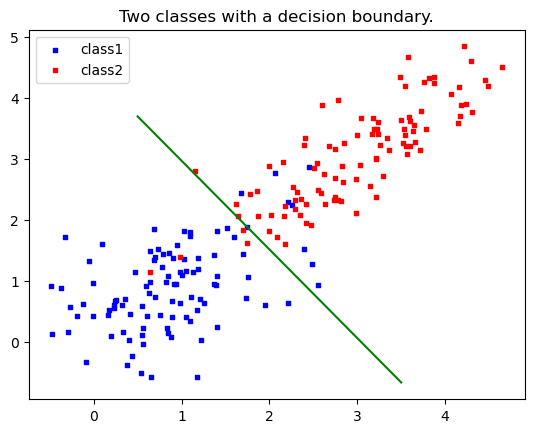

In [75]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(class1[:, 0], class1[:, 1], s=10, c='b', marker="s", label='class1')
ax1.scatter(class2[:, 0], class2[:, 1], s=10, c='r', marker="s", label='class2')
x1 = jnp.linspace(.5, 3.5, 50)
x2 = ( -theta[0]*x1 - theta[2])/theta[1]
ax1.plot(x1, x2, c='g')
plt.title('Two classes with a decision boundary.')
plt.legend()


In [ ]:
theta[2]

Array(5.084245, dtype=float32)

### Fully connected neural network.

$x \in R^n$, an input vector, transformed to a vector of length $m$ via 
$$
x = xW + b, \newline
x = activation\_function(x),
$$
where $W \in R^{n\times m}, b \in R^m$.
This represents one layer of the network. The final layer transforms to the dimension of the output, and in case of classsification - sigmoid.


In [76]:
# A link to the data is availailable in the following blog post
# https://scipython.com/blog/a-shallow-neural-network-for-simple-nonlinear-classification/
df = pd.read_csv('../non_linear_class_example/labeled_points.txt', sep=' ',
                usecols=[1,3,5], names=['x1', 'x2', 'label'])

In [77]:
df.head()

,x1,x2,label
0,0.50873,0.08490,1
1,0.96767,0.96752,1
2,0.72096,0.90628,1
3,0.66071,0.32757,1
4,0.48690,0.58265,0


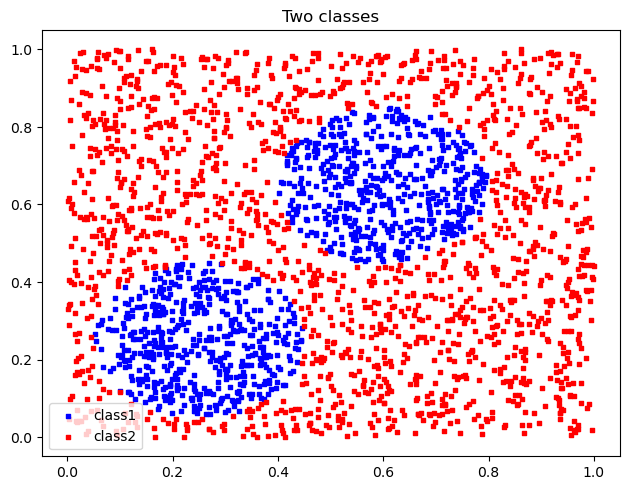

In [78]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
df_cl1 = df[df.label == 0]
df_cl2 = df[df.label == 1]
ax1.scatter(df_cl1.x1, df_cl1.x2, s=5, c='b', marker="s", label='class1')
ax1.scatter(df_cl2.x1, df_cl2.x2, s=5, c='r', marker="s", label='class2')
fig.tight_layout()
plt.title('Two classes')
plt.legend()


In [80]:
# 
x = jnp.array(df[['x1', 'x2']])
y = jnp.array(df['label'])
print(x.shape)
print(y.shape)

(2506, 2)
(2506,)


In [81]:
#first point
print(x[0])
# W dim
input_dim = 2
hidden_dim = 10
#key = jax.random.PRNGKey(42)
#key, subkey = random.split(key)
#print(random.normal(subkey, shape=(5,)))
print('init inputs with random numbers:')
W = jax.random.normal(key, shape=(input_dim, hidden_dim)) * .01
b = jax.random.normal(key, shape=(1, hidden_dim)) * .01
W1 = jax.random.normal(key, shape=(hidden_dim, hidden_dim)) * .01
b1 = jax.random.normal(key, shape=(1, hidden_dim)) * .01
w = jax.random.normal(key, shape=(hidden_dim, 1)) * .01
print('dimensions:')
print('W:', W.shape)
print('b:', b.shape)
print('W1:', W1.shape)
print('b1:', b1.shape)
print('w:', w.shape)
print('model:')
print(model((W, b, W1, b1, w), x[0:10]))
print('loss function:')
print(loss_fn((W, b, W1, b1, w), x[0:10], y[0:10]))
print('gradient dim:')
print(list(map(lambda i: i.shape, grad(loss_fn)((W, b, W1, b1, w), x[0:5], y[0:5]))))

[0.50873 0.0849 ]
init inputs with random numbers:
dimensions:
W: (2, 10)
b: (1, 10)
W1: (10, 10)
b1: (1, 10)
w: (10, 1)
model:


TypeError: dot requires ndarray or scalar arguments, got <class 'tuple'> at position 0.

In [82]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(
    x, 
    y,
    stratify=y,
    test_size=0.3, random_state=212
)
print(list(map(lambda i: i.shape, (X_train, X_test, y_train, y_test))))
print(y_train.sum(), y_test.sum())

[(1754, 2), (752, 2), (1754,), (752,)]
1051 451


#### 2-layer nn using optax for optimization

In [83]:
key, w1key, b1key, w2key, b2key, w3key, b3key = jax.random.split(key, 7)
num_input = X_train.shape[1]
num_hidden1 = 100
num_hidden2 = 100
num_labels = y_train.max() + 1
print('Dimensions are ', num_input, num_hidden1, num_labels)
#num_hidden2 = 1024
params = dict(
    w1 = 1e-2*jax.random.normal(w1key, (num_input, num_hidden1)),
    b1 = 1e-2*jax.random.normal(b1key, (1, num_hidden1)),
    w2 = 1e-2*jax.random.normal(w2key, (num_hidden1, num_hidden2)),
    b2 = 1e-2*jax.random.normal(b2key, (1, num_hidden2)),
    w3 = 1e-2*jax.random.normal(w3key, (num_hidden2, num_labels)),
    b3 = 1e-2*jax.random.normal(b3key, (1, num_labels)),
)
for k in params.keys():
    print(f'Dimensions of {k} are ', params[k].shape)

Dimensions are  2 100 2
Dimensions of w1 are  (2, 100)
Dimensions of b1 are  (1, 100)
Dimensions of w2 are  (100, 100)
Dimensions of b2 are  (1, 100)
Dimensions of w3 are  (100, 2)
Dimensions of b3 are  (1, 2)


In [84]:
@jax.jit
def net(params, x):
    x = jax.nn.relu(x@params["w1"] + params["b1"])
    x = jax.nn.relu(x@params["w2"] + params["b2"])
    x = x@params["w3"] + params["b3"]
#    x = sigmoid(x)
    return x

In [85]:
@jax.jit
def loss(params: optax.Params, batch: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
  y_hat = net(params, batch)

  # optax also provides a number of common loss functions.
  loss_value = optax.sigmoid_binary_cross_entropy(y_hat, labels).sum(axis=-1)

  return loss_value.mean()

loss(params, X_train, jax.nn.one_hot(y_train, 2))

Array(1.3849983, dtype=float32)

In [86]:
@jax.jit
def xeloss(x, y):
    _elementwise_xeloss = jax.vmap(lambda x, y: -jax.nn.log_softmax(x)[y])
    #print(_elementwise_xeloss(x, y))
    return _elementwise_xeloss(x, y).mean()

In [87]:
print('model:')
print(net(params, x[0:10]))
print('loss functions:')
print(xeloss(net(params, x[0:10]), y[0:10]))
print(loss(params, net(params, x[0:10]), jax.nn.one_hot(y[0:10], 2)))

model:
[[0.00013565 0.01345432]
 [0.00017942 0.01341061]
 [0.000179   0.01341772]
 [0.00014493 0.0134439 ]
 [0.00016437 0.01343642]
 [0.00013976 0.01343746]
 [0.00012404 0.01347168]
 [0.00015432 0.01344244]
 [0.00016074 0.0134269 ]
 [0.00014328 0.01344578]]
loss functions:
0.69051343
1.3836566


In [88]:
@jax.jit
def accuracy(x, y):
    return 100*(jnp.argmax(x, 1) == y).mean()
accuracy(net(params, x[0:10]), y[0:10])

Array(70., dtype=float32)

In [89]:
@jax.jit
def lossforward(params, x, y):
    x = net(params, x)
    loss = xeloss(x, y)
    return loss
lossforward(params, x[0:10], y[0:10])

Array(0.69051343, dtype=float32)

In [90]:
print(y[0:10])
jax.nn.one_hot(y[0:10], 2)

[1 1 1 1 0 0 1 1 1 0]


Array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [93]:
#import optax
optax.sigmoid_binary_cross_entropy(net(params, x[0:10]), jax.nn.one_hot(y[0:10], 2)).sum(axis=-1).mean()

Array(1.383661, dtype=float32)

In [94]:
print(-jnp.log(sigmoid(net(params, x[0:10]))) * jax.nn.one_hot(y[0:10], 2))
print(-jnp.log(sigmoid(-net(params, x[0:10]))) * (1-jax.nn.one_hot(y[0:10], 2)))
print(-jnp.log(sigmoid(net(params, x[0:10]))) * jax.nn.one_hot(y[0:10], 2) -
    jnp.log(sigmoid(-net(params, x[0:10]))) * (1-jax.nn.one_hot(y[0:10], 2)))
xe = (-jnp.log(sigmoid(net(params, x[0:10]))) * jax.nn.one_hot(y[0:10], 2) -
    jnp.log(sigmoid(-net(params, x[0:10]))) * (1-jax.nn.one_hot(y[0:10], 2)))
xe.sum(axis=-1).mean()

[[0.         0.68644273]
 [0.         0.68646437]
 [0.         0.68646085]
 [0.         0.6864478 ]
 [0.6930649  0.        ]
 [0.6930773  0.        ]
 [0.         0.6864341 ]
 [0.         0.68644863]
 [0.         0.6864563 ]
 [0.69307554 0.        ]]
[[0.693215   0.        ]
 [0.6932368  0.        ]
 [0.6932367  0.        ]
 [0.69321966 0.        ]
 [0.         0.6998879 ]
 [0.         0.69988847]
 [0.6932092  0.        ]
 [0.69322443 0.        ]
 [0.6932275  0.        ]
 [0.         0.69989264]]
[[0.693215   0.68644273]
 [0.6932368  0.68646437]
 [0.6932367  0.68646085]
 [0.69321966 0.6864478 ]
 [0.6930649  0.6998879 ]
 [0.6930773  0.69988847]
 [0.6932092  0.6864341 ]
 [0.69322443 0.68644863]
 [0.6932275  0.6864563 ]
 [0.69307554 0.69989264]]


Array(1.383661, dtype=float32)

In [95]:
jnp.log(sigmoid(-0.00092671))

Array(-0.6936107, dtype=float32, weak_type=True)

In [96]:
jnp.log(jax.nn.sigmoid(-0.00092671))

Array(-0.6936107, dtype=float32, weak_type=True)

In [97]:
jax.nn.log_sigmoid(-0.00092671)

Array(-0.6936107, dtype=float32, weak_type=True)

In [98]:
X_train.shape

(1754, 2)

In [111]:
# optimizer
# import optax
# learning_rate = 0.001
batch_size = 1000
train_size = X_train.shape[0]
num_steps = 5000
def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, batch, labels):
        loss_value, grads = jax.value_and_grad(loss)(params, batch, labels)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    key = jax.random.PRNGKey(42)
    for i in range(num_steps):
        # draw a batch randomly from training set
        key, key1 = jax.random.split(key)
        idxs = jax.random.randint(key1, (batch_size,), 0, train_size)
        x = X_train[idxs]
        y = jax.nn.one_hot(y_train[idxs], 2)

        params, opt_state, loss_value = step(params, opt_state, x, y)
        if i % 100 == 0:
          print(f'step {i}, loss: {loss_value}')

    return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.adam(learning_rate=1e-1)
params = fit(params, optimizer)


step 0, loss: 0.30800119042396545
step 100, loss: 0.2980051636695862
step 200, loss: 0.37304094433784485
step 300, loss: 0.3044019043445587
step 400, loss: 0.3810301721096039
step 500, loss: 0.3174772560596466
step 600, loss: 0.30186763405799866
step 700, loss: 0.3340805470943451
step 800, loss: 0.28965190052986145
step 900, loss: 0.3332858383655548
step 1000, loss: 0.2863539755344391
step 1100, loss: 0.29791319370269775
step 1200, loss: 0.36586833000183105
step 1300, loss: 0.3075803816318512
step 1400, loss: 0.33505165576934814
step 1500, loss: 0.3435748815536499
step 1600, loss: 0.3336401581764221
step 1700, loss: 0.3090008497238159
step 1800, loss: 0.35675758123397827
step 1900, loss: 0.3169739544391632
step 2000, loss: 0.34567439556121826
step 2100, loss: 0.2790144085884094
step 2200, loss: 0.3453656733036041
step 2300, loss: 0.25979986786842346
step 2400, loss: 0.3037690222263336
step 2500, loss: 0.2976619005203247
step 2600, loss: 0.3018406629562378
step 2700, loss: 0.33184891939

In [106]:
loss(params, X_train, jax.nn.one_hot(y_train, 2))

Array(0.3559274, dtype=float32)

In [107]:
net(params, X_train)[:, 1] #, jax.nn.one_hot(y_train, 2))

Array([ 2.0603037, -6.248559 , -5.8633833, ...,  9.663134 , -6.248559 ,
       -6.248559 ], dtype=float32)

In [108]:
jnp.round(sigmoid(net(params, X_train)[:, 1]),0)

Array([1., 0., 0., ..., 1., 0., 0.], dtype=float32)

In [112]:
# performance metrics on training set
binary_classification_metrics(y_train,
                              jnp.round(sigmoid(net(params, X_train)[:, 1]),0),
                              sigmoid(net(params, X_train)[:, 1]),
                              4
                             )

,Prevalence,Sensitivity,Specificity,Accuracy,Precision,F1,FPR,MCC,AUC,LogLoss
0,0.5992,0.8963,0.9929,0.935,0.9947,0.9429,0.0071,0.8743,0.974,0.1581


In [113]:
# performance metrics on validation set
binary_classification_metrics(y_test,
                              jnp.round(sigmoid(net(params, X_test)[:, 1]),0),
                              sigmoid(net(params, X_test)[:, 1]),
                              4
                             )

,Prevalence,Sensitivity,Specificity,Accuracy,Precision,F1,FPR,MCC,AUC,LogLoss
0,0.5997,0.878,0.9801,0.9189,0.9851,0.9285,0.0199,0.8429,0.9688,0.1773


In [ ]:
# @jax.jit
# def train_step(step, optim_state, x, y):
#     params = optim_params(optim_state)
#     loss, grads = jax.value_and_grad(lossforward)(params, x, y)
#     optim_state = optim_update(step, grads, optim_state)
#     return loss, optim_state

In [ ]:
# history = []
# batch_size = 100
# num_steps = 2000
# for step in range(num_steps):
#     if step%200 == 0 or step == num_steps - 1:
#         valid_logits = forward(optim_params(optim_state), valid_values)
#         valid_loss = xeloss(valid_logits, valid_labels)
#         valid_accuracy = accuracy(valid_logits, valid_labels)
#         history.append((step, valid_loss, valid_accuracy))
#         print(f"Step {step:5.0f}\t Valid. Acc. = {valid_accuracy:5.2f}")
#     prng, key = jax.random.split(prng)
#     idxs = jax.random.randint(key, (batch_size,), 0, train_size)
#     x = train_values[idxs]
#     y = train_labels[idxs]
#     loss, optim_state = train_step(step, optim_state, x, y)

### LSTM by chatGPT

In [ ]:
import jax.numpy as np
from jax import grad, jit, vmap

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def lstm_cell(hidden_state, cell_state, input_vector, params):
    W_f, b_f, W_i, b_i, W_o, b_o, W_c, b_c = params

    # forget gate
    forget_gate = sigmoid(np.dot(input_vector, W_f) + np.dot(hidden_state, W_f) + b_f)

    # input gate
    input_gate = sigmoid(np.dot(input_vector, W_i) + np.dot(hidden_state, W_i) + b_i)

    # candidate cell state
    candidate_cell_state = tanh(np.dot(input_vector, W_c) + np.dot(hidden_state, W_c) + b_c)

    # cell state
    cell_state = forget_gate * cell_state + input_gate * candidate_cell_state

    # output gate
    output_gate = sigmoid(np.dot(input_vector, W_o) + np.dot(hidden_state, W_o) + b_o)

    # hidden state
    hidden_state = output_gate * tanh(cell_state)

    return hidden_state, cell_state

def lstm(inputs, initial_hidden_state, initial_cell_state, params):
    def step(hidden_state_and_cell_state, input_vector):
        hidden_state, cell_state = hidden_state_and_cell_state
        new_hidden_state, new_cell_state = lstm_cell(hidden_state, cell_state, input_vector, params)
        return new_hidden_state, new_cell_state
    hidden_states, cell_states = np.scan(step, inputs, (initial_hidden_state, initial_cell_state))
    return hidden_states, cell_states

# example usage
inputs = np.array([[1, 2, 3], [4, 5, 6]])
initial_hidden_state = np.zeros((2, 10))
initial_cell_state = np.zeros((2, 10))
params = [np.zeros((3, 10)), np.zeros(10), np.zeros((3, 10)), np.zeros(10), np.zeros((3, 10)), np.zeros(10), np.zeros((3, 10)), np.zeros(10)]

hidden_states, cell_states = lstm(inputs, initial_hidden_state, initial_cell_state, params)


AttributeError: module 'jax.numpy' has no attribute 'scan'